Used for testing some parameters might not be optimal.

See final_training for optimal version

In [ ]:
import numpy as np
import cv2
from google.colab import drive
import gc
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, load_img
import tensorflow as tf
import random

import os

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Conv2D , MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# constants
IMG_DIM = (110,110)
EPOCHS = 2
LEARNING_RATE = 0.0003
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SHUFFLE = True
ROLLING_MEAN = 21

SIZE_KITTI = 2811
SIZE_2k19 = 25000

In [ ]:
drive.mount('/content/drive/')
root_kitti = "drive/MyDrive/Colab Notebooks/commaai/data/KITTI/"
root_2k19 = "drive/MyDrive/Colab Notebooks/commaai/data/2k19/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#image prep functions

def opticalFlow(frame1,frame2, x, w, y, h):
    frame1 = frame1[y:y+h, x:x+w]
    frame2 = frame2[y:y+h, x:x+w]

    flow = np.zeros_like(frame1)
    frame1 = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow_data = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 0.4, 1, 12, 2, 8, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow_data[...,0], flow_data[...,1])
    mag = (mag *15).astype(int)
    ang = ang*180/np.pi/2
    flow[...,1] = 255
    flow[...,0] = ang
    flow[...,2] = mag
    return flow

def getImagesFrom2k19(path):
    images = []
    cap = cv2.VideoCapture(path)
    ret, prev = cap.read()
    while True:
        ret, next  = cap.read()
        if not ret:
            break
        flow = opticalFlow(prev,next, 9, 1146, 213, 382)
        flow = cv2.resize(flow, IMG_DIM, interpolation = cv2.INTER_AREA)
        images.append(flow/127.5 - 1)
        prev = next
    images = np.array(images)
    return images

def getImagesFromMain(path):
    images = []
    cap = cv2.VideoCapture(path)
    ret, prev = cap.read()
    while True:
        ret, next  = cap.read()
        if not ret:
            break
        flow = opticalFlow(prev,next, 5, 630, 140, 210)
        flow = cv2.resize(flow, IMG_DIM, interpolation = cv2.INTER_AREA)
        images.append(flow/127.5 - 1)
        prev = next
    images = np.array(images)
    return images

def getImagesFromKitti(path, size):
    images = []
    prev = cv2.imread(path+"0000000000.png")
    for i in range(1, size):
        try:
            fn = str(i).zfill(10)+".png"
            next = cv2.imread(path+fn)
            flow = opticalFlow(prev,next, 59, 1125, 0, 375)
            flow = cv2.resize(flow, IMG_DIM, interpolation = cv2.INTER_AREA)
            images.append(flow/127.5 - 1)
            prev = next
        except:
            break
    images = np.array(images)
    return images
    
gc.collect()

37

In [ ]:
def getLabelsFromTXT(path):
    labels = []
    f = open(path,'r')
    for l in f:
        labels.append(float(l))
    labels = np.array(labels)
    return labels

# 2k19 saves timestamaps not connected to each frame
def getLabelsFrom2k19(Y_path, t_path):
    values = np.load(Y_path).flatten()
    times = np.load(t_path).flatten()
    Y = []
    count = 0
    for i, t in enumerate(times):
        if float(t) - float(times[0]) > count:
            Y.append(values[i])
            count+= (1/20)
    return np.array(Y)

# Going through 1 file per label is expensive, save results in another file
def saveKittiLabels(folder_id, size):
    speeds = []
    for i in range(size):
        fn = str(i).zfill(10)+".txt"
        f = open(root_kitti + folder_id + "/oxts/data/"+fn, "r")
        # 8th value is the speed
        speed = f.read().split()[8]
        speeds.append(speed)
    with open(root_kitti+ folder_id + "/labels.txt", "w") as f:
        for speed in speeds:
            f.write(str(speed)+"\n")

gc.collect()

174

In [ ]:
def getModel():
    model = Sequential()
    model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2),activation='relu'))
    model.add(Conv2D(filters=36, kernel_size=(5, 5),strides=(2, 2), activation='relu'))
    model.add(Conv2D(filters=48, kernel_size=(5, 5), strides=(2, 2),activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3) ,activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3),activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=10, activation='relu'))
    model.add(Dense(units=1))

    model.compile(loss='mse',optimizer= tf.keras.optimizers.Adam(lr=LEARNING_RATE))
    return model
    
gc.collect()

22

In [ ]:
def plot(history):
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training', 'validation'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.show()
gc.collect()

22

In [ ]:
def rollingMean(mylist):
    if isinstance(mylist, np.ndarray):
        mylist = mylist.tolist()
    avrg = []

    first = 0
    for i in range(ROLLING_MEAN):
        first += (mylist[max(i-ROLLING_MEAN//2, 0)] / ROLLING_MEAN)
    avrg.append(first)
    
    for i in range(1, len(mylist)):
        last = avrg[i-1] * ROLLING_MEAN
        past = mylist[max(i-1-ROLLING_MEAN//2, 0)]
        new =  mylist[min(i+ROLLING_MEAN//2, len(mylist)-1)]
        avrg.append((last - past + new)/ROLLING_MEAN)
    return np.array(avrg)

In [ ]:
def clacMSE(pred):
    mse = 0
    for i, v in enumerate(pred):
        mse +=  (Y_main[i] - v) * (Y_main[i] - v)
    mse /= len(Y_main)
    return mse


In [ ]:
predictions = []
predictions_mean = []
def trainModel(X, Y, epoch, model):
    history = model.fit(X, Y, 
                        validation_split=VAL_SPLIT, 
                        batch_size=BATCH_SIZE, 
                        epochs=epoch, 
                        shuffle = SHUFFLE,
                        verbose=2)
            
    plot(history)
    
    print("Evaluating: ")
    model.evaluate(X_main, Y_main, batch_size=BATCH_SIZE)

    results = model.predict(X_main, batch_size=BATCH_SIZE)
    print("1", type(results), type(results[0]))
    results = results.flatten()
    print("2", type(results), type(results[0]))
    results_mean = rollingMean(results)
    print("3", type(results_mean), type(results_mean[0]))
    print("MSE clac: ")
    print(clacMSE(results))
    print("MSE mean clac: ")
    print(clacMSE(results_mean))

    predictions.append(results)
    predictions_mean.append(results_mean)
    print("Mean of results: ",results.mean())
    print("Mean of results with rolling mean: ",results_mean.mean())
    print("Mean of training data: ",Y.mean())
    return model



In [ ]:
X_path_main = "drive/MyDrive/Colab Notebooks/commaai/data/train.mp4"
Y_path_main = "drive/MyDrive/Colab Notebooks/commaai/data/train.txt"

Y_main = getLabelsFromTXT(Y_path_main)
X_main = getImagesFromMain(X_path_main)
Y_main = Y_main[:len(X_main)]

X_main = X_main[:,:,:,[0,2]]


gc.collect()

len(Y_main)

20399

In [ ]:
X_kitti = np.array([]).reshape(0, IMG_DIM[0], IMG_DIM[1], 2)
Y_kitti = np.array([])

Y_kitti2 = np.array([])

folders_kitti = os.listdir(root_kitti)
count = 0

def getMoreKitti():
    global Y_kitti
    global X_kitti
    global Y_kitti2
    global folders_kitti
    global count
    if count < len(folders_kitti):
        folder_id = folders_kitti[count]
        count += 1
        print("In dir:", root_kitti + folder_id)

        X_path = root_kitti + folder_id + "/image_03/data/"
        Y_path = root_kitti + folder_id + "/labels.txt"
        num_photos = len(os.listdir(X_path))

        if not os.path.isfile(Y_path):
            saveKittiLabels(folder_id, num_photos)
        Y_kitti_batch = getLabelsFromTXT(Y_path)
        
        X_kitti_batch = getImagesFromKitti(X_path, num_photos)

        X_kitti_batch = X_kitti_batch[:,:,:,[0,2]]

        #double the speed because fps is half (10 not 20)
        
        Y_kitti_batch = Y_kitti_batch[:len(X_kitti_batch)]
        Y_kitti_batch2 = Y_kitti_batch*2
        if len(Y_kitti_batch) == len(X_kitti_batch):
            return (X_kitti_batch, Y_kitti_batch, Y_kitti_batch2)
    return (np.array([]).reshape(0, IMG_DIM[0], IMG_DIM[1], 2), np.array([]), np.array([]))

def getAllKitti():
    while True:
        X_kitti_batch, Y_kitti_batch, Y_kitti_batch2 = getMoreKitti()
        if len(Y_kitti_batch) == 0:
            break
        X_kitti = np.concatenate((X_kitti, X_kitti_batch))
        Y_kitti = np.concatenate((Y_kitti, Y_kitti_batch))
        Y_kitti2 = np.concatenate((Y_kitti2, Y_kitti_batch2))
        del X_kitti_batch, Y_kitti_batch, Y_kitti_batch2
        gc.collect()



def getKittiBatch():
    global Y_kitti
    global X_kitti
    global folders_kitti
    global count
    global Y_kitti2
    while len(Y_kitti) < SIZE_KITTI:
        X_kitti_batch, Y_kitti_batch, Y_kitti_batch2 = getMoreKitti()
        if len(Y_kitti_batch) == 0:
            break
        X_kitti = np.concatenate((X_kitti, X_kitti_batch))
        Y_kitti = np.concatenate((Y_kitti, Y_kitti_batch))
        Y_kitti2 = np.concatenate((Y_kitti2, Y_kitti_batch2))
        del X_kitti_batch, Y_kitti_batch
        gc.collect()
    X_ret = X_kitti[:SIZE_KITTI]
    Y_ret = Y_kitti[:SIZE_KITTI]
    Y_ret2 = Y_kitti2[:SIZE_KITTI]
    X_kitti = X_kitti[SIZE_KITTI:]
    Y_kitti = Y_kitti[SIZE_KITTI:]
    Y_kitti2 = Y_kitti2[SIZE_KITTI:]
    gc.collect()
    return (X_ret, Y_ret, Y_ret2)

gc.collect()

0

Path: drive/MyDrive/Colab Notebooks/commaai/data/2k19/Chunk_1/b0c9d2329ad1606b_2018-08-15--09-01-03/20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean:  nan
1197
Path: drive/MyDrive/Colab Notebooks/commaai/data/2k19/Chunk_1/b0c9d2329ad1606b_2018-08-15--09-01-03/23
Path: drive/MyDrive/Colab Notebooks/commaai/data/2k19/Chunk_1/b0c9d2329ad1606b_2018-08-15--09-01-03/17
Path: drive/MyDrive/Colab Notebooks/commaai/data/2k19/Chunk_1/b0c9d2329ad1606b_2018-08-15--09-01-03/21
Path: drive/MyDrive/Colab Notebooks/commaai/data/2k19/Chunk_1/b0c9d2329ad1606b_2018-08-15--09-01-03/22
Path: drive/MyDrive/Colab Notebooks/commaai/data/2k19/Chunk_1/b0c9d2329ad1606b_2018-08-15--09-01-03/19
Path: drive/MyDrive/Colab Notebooks/commaai/data/2k19/Chunk_1/b0c9d2329ad1606b_2018-08-15--09-01-03/18
Path: drive/MyDrive/Colab Notebooks/commaai/data/2k19/Chunk_1/b0c9d2329ad1606b_2018-08-15--09-01-03/16
Path: drive/MyDrive/Colab Notebooks/commaai/data/2k19/Chunk_1/b0c9d2329ad1606b_2018-08-06--10-04-53/34
Path: drive/MyDrive/Colab Notebooks/commaai/data/2k19/Chunk_1/b0c9d2329ad1606b_2018-08-06--10-04-53/35
Mean:  25.589172584238376
2397
Path: drive/MyDrive/Colab 

KeyboardInterrupt: ignored

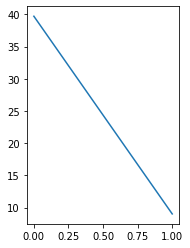

In [ ]:
folder_chunk = "Chunk_"
chunks = 6
target_mean = 13.18

X = np.array([]).reshape(0, IMG_DIM[0], IMG_DIM[1], 2)
Y = np.array([])

model = getModel()

model2 = getModel()
model3 = getModel()

for chunk in range(1,chunks+1):
    for folder_id in os.listdir(root_2k19+folder_chunk+str(chunk)):
        for folder_number in os.listdir(root_2k19+folder_chunk+str(chunk)+"/"+folder_id):
            path = root_2k19+folder_chunk+str(chunk)+"/"+folder_id+"/"+folder_number
            print("Path:", path)

            if (7 < int(folder_id[29 : 31]) < 18):
                try:
                    labels_path = path+"/processed_log/CAN/speed/value"
                    times_path = path+"/processed_log/CAN/speed/t"
                    video_path = path+"/video.hevc"

                    Y_batch = getLabelsFrom2k19(labels_path, times_path)
                    if (len(Y) == 0 or (Y.mean() > target_mean and Y_batch.mean() < target_mean) or (Y.mean() < target_mean and Y_batch.mean() > target_mean)):
                        X_batch = getImagesFrom2k19(video_path)

                        X_batch = X_batch[:,:,:,[0,2]]

                        Y_batch = Y_batch[:len(X_batch)]

                        print("Mean: ", Y.mean())

                        if len(Y_batch) == len(X_batch):
                            X = np.concatenate((X, X_batch))
                            Y = np.concatenate((Y, Y_batch))
                        print(len(X))

                        if len(X) > SIZE_2k19:


                            X_kitti_batch, Y_kitti_batch, Y_kitti_batch2 = getKittiBatch()
                            print("len kitti:", len(Y_kitti_batch))


                            X = np.concatenate((X, X_kitti_batch))
                            Y2 = np.concatenate((Y, Y_kitti_batch2))
                            Y = np.concatenate((Y, Y_kitti_batch))
                            
                            del X_kitti_batch, Y_kitti_batch, Y_kitti_batch2
                            
                            gc.collect()

                            model = trainModel(X,Y, 2, model)
                            model2 = trainModel(X,Y2, 2, model2)
                            model3 = trainModel(X,Y, 10, model3)

                            X = np.array([]).reshape(0, IMG_DIM[0], IMG_DIM[1], 2)
                            Y = np.array([])
                            gc.collect()
                except Exception as e:
                    print("ERROR",e)
            gc.collect()


getAllKitti()
print("Last kitti batch:", len(Y_kitti))
X = np.concatenate((X, X_kitti))
Y = np.concatenate((Y, Y_kitti))
Y2 = np.concatenate((Y, Y_kitti2))
del X_kitti, Y_kitti, Y_kitti2
gc.collect()

model = trainModel(X,Y, 2, model)
model2 = trainModel(X,Y2, 2, model2)
model3 = trainModel(X,Y, 10, model3)

In [ ]:
model.save("drive/MyDrive/Colab Notebooks/commaai/model_24_wo.h5")

In [ ]:
del X, Y

In [ ]:
test_path = "drive/MyDrive/Colab Notebooks/commaai/data/test.mp4"
X_test = getImagesFromMain(test_path)
X_test = X_test[:,:,:,[0,2]]


In [ ]:
# history = model.fit(X_main, Y_main, 
#                         validation_split=VAL_SPLIT, 
#                         batch_size=BATCH_SIZE, 
#                         epochs=10, 
#                         shuffle = SHUFFLE,
#                         verbose=2)

In [ ]:
#del X, Y

In [ ]:
# test_path = "drive/MyDrive/Colab Notebooks/commaai/data/test.mp4"
# X_test = getImagesFromMain(test_path)
# X_test = X_test[:,:,:,[0,2]]


In [ ]:
#predicted_speed = rollingMean(predicted_speed.flatten())

In [ ]:
#predicted_speed = model.predict(X_test, verbose=1)

In [ ]:
# with open("drive/MyDrive/Colab Notebooks/commaai/data/test_22_w.txt", "w") as f:
#     for speed in predicted_speed:
#         f.write(str(speed)+"\n")

In [ ]:
# predicted_speed = model.predict(X_test, verbose=1)

In [ ]:
# trainModel(X_main,Y_main)